/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


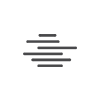

날씨 : 박무
온도 : 23.76 ℃
판매량 예측:  0.9544097632628548


In [1]:
import requests
import json
import pickle
import pymysql
from config import db_config  # config.py에서 db_config 가져오기
from datetime import datetime  # 요일 정보를 가져오기 위해 추가

# Constants
city = "Seoul"
apikey = "c1f6c98d79482985f66c26c037fe666a"
lang = "kr"
api = f"https://api.openweathermap.org/data/2.5/weather?q={city}&appid={apikey}&lang={lang}&units=metric"

try:
    # API 요청
    result = requests.get(api)
    result.raise_for_status()  # 잘못된 응답에 대해 예외 발생
    data = json.loads(result.text)

    if data["cod"] == 200:
        temperature = data['main']['temp']
        weather_description = data['weather'][0]['description']
        
        # 선형 회귀 모델 로드
        with open('linear_regression_model.pkl', 'rb') as file:
            loaded_model = pickle.load(file)

        # 테스트 데이터 준비
        x_test = [[temperature]]
        predictions = loaded_model.predict(x_test)
        predicted_sales = predictions[0][0] / 58.11

        # 요일 정보 가져오기
        current_weekday = datetime.now().weekday()  # 월요일=0, ..., 일요일=6

        # 요일에 따라 predicted_sales 조정
        if current_weekday in [0, 1, 2, 3]:  # 월~목
            predicted_sales *= 1
        elif current_weekday in [4, 5]:  # 금, 토
            predicted_sales *= 2
        elif current_weekday == 6:  # 일요일
            predicted_sales *= 1.5

        # 날씨 정보 저장
        weather_info = f"{weather_description}: {temperature}"
        
        # 데이터베이스에 연결
        conn = pymysql.connect(**db_config)
        with conn.cursor() as cursor:
            # inventory_management_table의 정보를 불러옴
            select_query = "SELECT * FROM inventory_management_table WHERE DATE(date_time) = CURDATE()"
            cursor.execute(select_query)
            inventory_result = cursor.fetchone()

            # 불러온 재고 정보 처리
            if inventory_result:
                flavor1 = inventory_result['flavor1'] * predicted_sales
                flavor2 = inventory_result['flavor2']
                flavor3 = inventory_result['flavor3']
                topping1 = inventory_result['topping1']
                topping2 = inventory_result['topping2']
                topping3 = inventory_result['topping3']

                rec_flavor1 = flavor1 * predicted_sales
                rec_flavor2 = flavor2 * predicted_sales
                rec_flavor3 = flavor3 * predicted_sales
                rec_topping1 = topping1 * predicted_sales
                rec_topping2 = topping2 * predicted_sales
                rec_topping3 = topping3 * predicted_sales
            # 주문 정보를 삽입
            insert_query = """
                INSERT INTO order_management_table (choco_order, vanila_order, strawberry_order, topping1_order, topping2_order, topping3_order, weather)
                VALUES (%s, %s, %s, %s, %s, %s, %s)
            """
            cursor.execute(insert_query, (rec_flavor1, rec_flavor2, rec_flavor3, rec_topping1, rec_topping2, rec_topping3, weather_info))
            conn.commit()  # 변경사항 커밋

except requests.exceptions.RequestException as e:
    print(f"API 요청 실패: {e}")
except Exception as e:
    print(f"오류 발생: {e}")
finally:
    if 'conn' in locals() and conn.open:
        conn.close()  # 데이터베이스 연결 닫기
